# Denoising Diffusion Probabilistic Models with miniai

Now that we written our own barebones training library, let's make some progress towards exploring diffusion model and building Stable Diffusion from scratch.

We'll start with building and training the model described in the seminal 2020 paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (DDPM). For more context, while diffusion models were technically invented [back in 2015](https://arxiv.org/abs/1503.03585), diffusion models flew under the radar until this 2020 paper since they were complicated and difficult to train. The 2020 paper introducing DDPMs made some crucial assumptions that significantly simplify the model training and generation processes, as we will see here. Later versions of diffusion models all build upon the same framework introduced in this paper.

Let's get started and train our own DDPM!

## Imports

We'll start with some imports.

In [ ]:
import logging
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib as mpl
import fastcore.all as fc
from matplotlib import pyplot as plt
from torch import tensor,nn,optim, einsum
from torch.utils.data import DataLoader,default_collate
from torchvision.utils import make_grid
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.learner import *
from miniai.augment import *
from miniai.conv import *
from fastcore.all import *
from fastprogress import progress_bar

In [ ]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

We will load the dataset from HuggingFace Hub:

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

To make life simpler (mostly with the model architecture), we'll resize the 28x28 images to 32x32:

In [ ]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

Let's set our batch size and create our DataLoaders with this batch size. we can confirm the shapes are correct. Note that while we do get the labels for the dataset, we actuallydon't care about that for our task of **unconditional** image generation.

In [ ]:
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

## Create model

We will create a U-net. A U-net looks something like this:

<img src="https://huggingface.co/blog/assets/78_annotated-diffusion/unet_architecture.jpg" width="700">

The DDPM U-net is a modification of this with some modern tricks like using attention.

We will cover how U-nets are created and how modules like attention work in future lessons. For now, we'll import the U-net from [lucidrains's DDPM repository](https://github.com/lucidrains/denoising-diffusion-pytorch):

In [ ]:
from ddpm_unet import Unet

In [ ]:
model = Unet(dim=32, channels=1, dim_mults=(1,2,2,))

## Training - easy with a callback!

DDPM is trained quite simply in a few steps:
1. randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to this timestep to the original image. For increasing timesteps, the variance of the noise increases.
3. Pass in this noisy image and the timestep to our model
4. Model is trained with an MSE loss between the model output and the amount of noise added to the image


We will implement this in a callback. The callback will randomly select the timestep and create the noisy image before setting up our input and ground truth tensors for the model forward pass and loss calculation.

After training, we need to sample from this model. This is an iterative denoising process starting from pure noise. We simply keep removing noise predicted by the neural network, but we do it with an expected noise schedule that is reverse of what we saw during training. This is also done in our callback.

In [ ]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, βmin, βmax):
        store_attr()
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps) # variance schedule, linearly increased with timestep
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()
    
    def train(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long) # select random timesteps
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)

        xt =  torch.sqrt(ᾱ_t)*x0 + torch.sqrt(1-ᾱ_t)*ε #noisify the image
        learn.batch = (xt, t, ε) # input to our model is noisy image and timestep, ground truth is the noise 
    
    def predict(self, learn): 
        if L(learn.cbs).filter(f=fc.risinstance(CapturePreds)): return
        learn.preds = learn.model(learn.batch[0],learn.batch[1])
    def get_loss(self, learn): 
        if L(learn.cbs).filter(f=fc.risinstance(CapturePreds)): learn.loss = torch.tensor(0)
        else: learn.loss = learn.loss_func(learn.preds, learn.batch[2])
    
    @torch.no_grad()
    def sample(self, learn):
        device = learn.batch[0].device
        x_t = torch.randn(learn.batch[0].shape, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            x_0_hat = ((x_t - b̄_t.sqrt() * learn.model(x_t, t_batch))/self.ᾱ[t].sqrt()).clamp(-1,1)
            x_t = x_0_hat * ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t + x_t * self.α[t].sqrt()*b̄_t1/b̄_t + self.σ[t]*z
            preds.append(x_t.cpu())
        learn.preds = preds
#        raise CancelBatchException()
 
    
    def before_batch(self, learn):
        if L(learn.cbs).filter(f=fc.risinstance(CapturePreds)): self.sample(learn)
        else: self.train(learn)
        
    
    def after_batch(self, learn):
        if L(learn.cbs).filter(f=fc.risinstance(CapturePreds)): raise CancelFitException

Okay now we're ready to train a model!

Let's create our `Learner`. We'll add our callbacks and train with MSE loss.

We specify the number of timesteps and the minimum and maximum variance for the DDPM model.

In [ ]:
cbs = [DDPMCB(n_steps=1000, βmin=0.0001, βmax=0.02), DeviceCB(), ProgressCB(),MetricsCB()]
learn = Learner(model, dls, nn.MSELoss(), lr=1e-3, cbs=cbs, opt_func=optim.Adam)

Now let's run the fit function:

In [ ]:
learn.fit(5)

loss,epoch,train
0.042,0,train
0.024,0,eval
0.021,1,train
0.020,1,eval
0.019,2,train
0.018,2,eval
0.018,3,train
0.018,3,eval
0.017,4,train
0.017,4,eval


## Inference

Now that we've trained our model, let's generate some images with our model:

In [ ]:
samples, _ = learn.capture_preds()

In [ ]:
len(samples[0])

1000

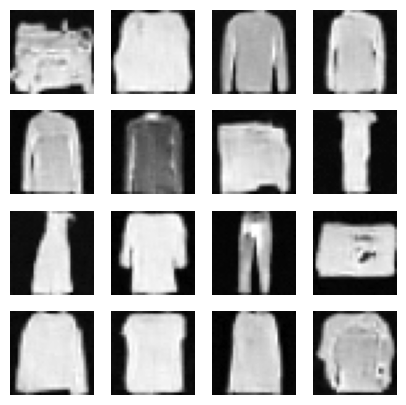

In [ ]:
show_images(-1*samples[0][-1][:16], figsize=(5,5))

With just 5 epochs of training we can get quite decent images! Let's visualize the sampling process.